### Investigation of Top Mass Reweighting

In [42]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [43]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras


import inspect

In [44]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

In [45]:
def preprocess_data(X):
    for x in X:
        normalize(x)
    
    # Remap PIDs to unique values in range [0,1]
    remap_pids(X, pid_i=3)
    return X

In [46]:
data_dir = 'DCTRFitting/'

### Load the truth data for top mass 172.5 and split 80% for training and 20% for testing

In [47]:
default_had_mass_all = np.load(data_dir + 'part_172_5_6j_obs.npy')[:,1]
default_had_mass = default_had_mass_all[:int(len(default_had_mass_all)*0.8)]
test_had_mass = default_had_mass_all[int(len(default_had_mass_all)*0.8):]

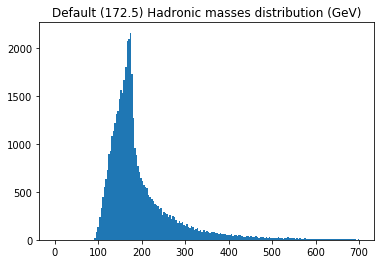

In [48]:
plt.hist(default_had_mass, bins = np.linspace(0,700,200))
plt.title("Default (172.5) Hadronic masses distribution (GeV)")
plt.show()

In [49]:
truth_had_mass = np.load(data_dir+ 'part_varmass_6j_obs.npy')[:,1][:len(default_had_mass)]

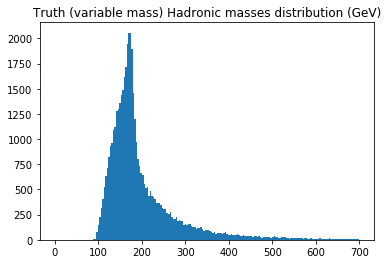

In [50]:
plt.hist(truth_had_mass, bins = np.linspace(0,700,200))
plt.title("Truth (variable mass) Hadronic masses distribution (GeV)")
plt.show()

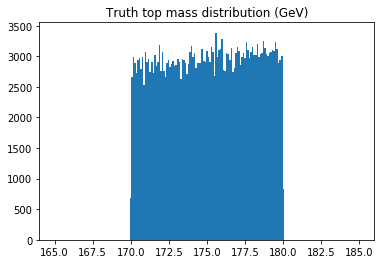

In [51]:
mu_values = np.load(data_dir+ 'part_varmass_6j.npy')[:,0,-1]
plt.hist(mu_values, bins = np.linspace(165,185,200))
plt.title("Truth top mass distribution (GeV)")
plt.show()

### Load top mass parameter

In [ ]:
mu_values = np.load(data_dir+ 'part_varmass_6j.npy')[:,0,-1]

### Prepare sample for DCTR reweighting

In [52]:
X0 = list(zip(default_had_mass, mu_values))
Y0 = to_categorical(np.zeros(len(X0)), num_classes=2)

In [53]:
X1 = list(zip(truth_had_mass, mu_values))
Y1 = to_categorical(np.ones(len(X1)), num_classes=2)

In [54]:
X = np.concatenate((X0, X1))
Y = np.concatenate((Y0, Y1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

### Define a 3 layer DNN for reweighting

In [55]:
inputs = Input((2,))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr_model = Model(inputs = inputs, outputs = outputs)
dctr_model.compile(loss='categorical_crossentropy', optimizer='Adam')

In [56]:
earlystopping = EarlyStopping(patience = 10,
                              restore_best_weights=True)
dctr_model.fit(X_train, Y_train, 
          epochs=20, 
          batch_size = 100,
          validation_data = (X_test, Y_test),
          callbacks = [earlystopping])


Train on 73868 samples, validate on 18468 samples
Epoch 1/20
73868/73868 [==============================] - 5s 61us/step - loss: 0.7659 - val_loss: 0.6978
Epoch 2/20
73868/73868 [==============================] - 4s 53us/step - loss: 0.7189 - val_loss: 0.6941
Epoch 3/20
73868/73868 [==============================] - 4s 55us/step - loss: 0.7026 - val_loss: 0.6992
Epoch 4/20
73868/73868 [==============================] - 4s 55us/step - loss: 0.7008 - val_loss: 0.6949
Epoch 5/20
73868/73868 [==============================] - 4s 53us/step - loss: 0.6969 - val_loss: 0.6964
Epoch 6/20
73868/73868 [==============================] - 4s 55us/step - loss: 0.6951 - val_loss: 0.6935
Epoch 7/20
73868/73868 [==============================] - 4s 55us/step - loss: 0.6940 - val_loss: 0.6930
Epoch 8/20
73868/73868 [==============================] - 4s 54us/step - loss: 0.6932 - val_loss: 0.6931
Epoch 9/20
73868/73868 [==============================] - 4s 54us/step - loss: 0.6932 - val_loss: 0.6933
Epoch

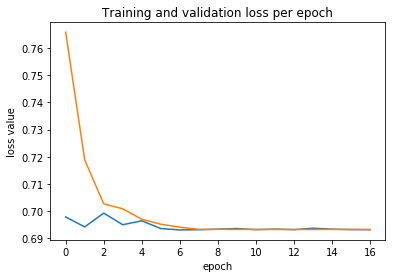

In [76]:
plt.title("Training and validation loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss value")
plt.plot(dctr_model.history.history['val_loss'])
plt.plot(dctr_model.history.history['loss'])
plt.show()

**Note** make a plot of training and validation

### Reweighting from data of mass 172.5 to 175

In [57]:
test_had_mass = np.load(data_dir + 'part_172_5_6j_obs.npy')[:,1]
X0_test = np.vstack([test_had_mass,172.5*np.ones(len(X0_test))]).T
X1_test = np.load(data_dir + 'part_175_0_6j_obs.npy')[:,1]
X1_test = np.vstack([X1_test,175*np.ones(len(X1_test))]).T

In [58]:
# Get predicted probabilities
preds_0 = dctr_model.predict(X0_test, batch_size=1000)
preds_1 = dctr_model.predict(X1_test, batch_size=1000)

In [59]:
weights_0 = preds_0[:,0]/preds_0[:,1]
weights_1 = preds_1[:,0]/preds_1[:,1]

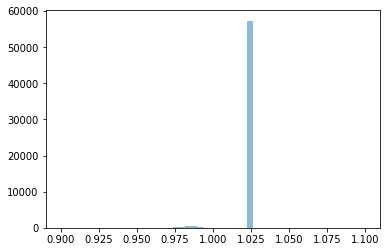

In [60]:
bins = np.linspace(0.9,1.1,50)
plt.hist(weights_1, bins = bins, alpha = 0.5, label = 'm = 172.5')[0]
plt.show()

In [62]:
print(max(weights_0))
print(max(1/weights_0))
print(max(weights_1))
print(max(1/weights_1))

1.0246252
1.1851711
1.0246065
1.1912415


In [63]:
weights_0.shape, X0_test.shape

((57710,), (57710, 2))

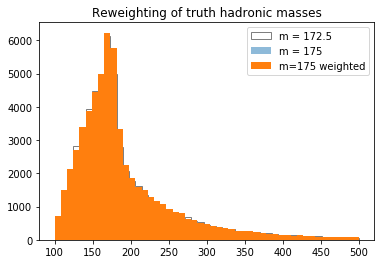

In [64]:
bins = np.linspace(100,500,50)
plt.title("Reweighting of truth hadronic masses")
default_data_hist = plt.hist(X0_test[:,0], bins = bins, alpha = 0.5, label = 'm = 172.5',histtype='step', color='k')[0]
target_data_hist = plt.hist(X1_test[:,0], bins = bins, alpha = 0.5, label = 'm = 175')[0]
reweight_data_hist = plt.hist(X1_test[:,0], bins = bins, label = 'm=175 weighted', weights=weights_1)[0]
plt.legend()
plt.show()

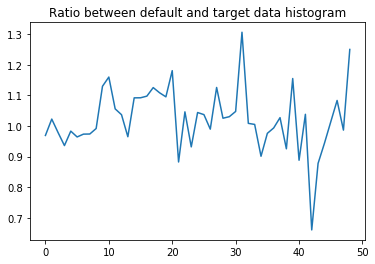

In [65]:
plt.title("Ratio between default and target data histogram")
plt.plot(target_data_hist/default_data_hist)
plt.show()

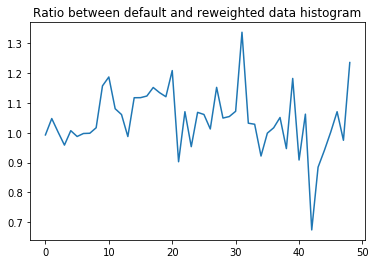

In [66]:
plt.title("Ratio between default and reweighted data histogram")
plt.plot(reweight_data_hist/default_data_hist)
plt.show()

In [67]:
X0_test = np.load(data_dir + 'det_172_5_6j_obs.npy')[:,1]
X0_test = np.vstack([X0_test,172.5*np.ones(len(X0_test))]).T
X1_test = np.load(data_dir + 'det_175_0_6j_obs.npy')[:,1]
X1_test = np.vstack([X1_test,175*np.ones(len(X1_test))]).T

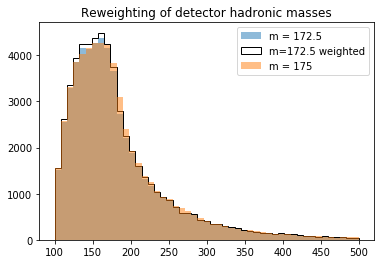

In [68]:
bins = np.linspace(100,500,50)
plt.title("Reweighting of detector hadronic masses")
default_data_hist = plt.hist(X0_test[:,0], bins = bins, alpha = 0.5, label = 'm = 172.5')[0]
reweight_data_hist = plt.hist(X0_test[:,0], bins = bins, label = 'm=172.5 weighted', weights=weights_0, histtype='step', color='k')[0]
target_data_hist = plt.hist(X1_test[:,0], bins = bins, alpha = 0.5, label = 'm = 175')[0]
plt.legend()
plt.show()

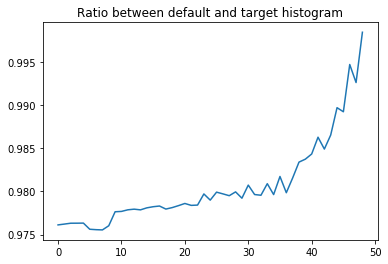

In [69]:
plt.title("Ratio between default and target histogram")
plt.plot(default_data_hist/reweight_data_hist)
plt.show()